In [1]:
from scipy import stats
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
import time

/Users/jshusko/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
font = {'size'   : 18}
import matplotlib
matplotlib.rc('font', **font)
seed = 1000

# Question 5 
### Bayesian Location-Scale Mixture of Normals fit using Gibbs Sampling on Galaxies dataset
dataset: https://r-data.pmagunia.com/dataset/r-dataset-package-mass-galaxies

In [3]:
# open galaxies dataset
with open('galaxies.csv') as galaxies:
    df = pd.read_csv(galaxies)
velocities = df["x"]/1000 # unpack and scale down to Megameters/sec
df.describe()

,x
count,82.000000
mean,20828.170732
std,4563.757994
min,9172.000000
25%,19532.000000
50%,20833.500000
75%,23133.000000
max,34279.000000


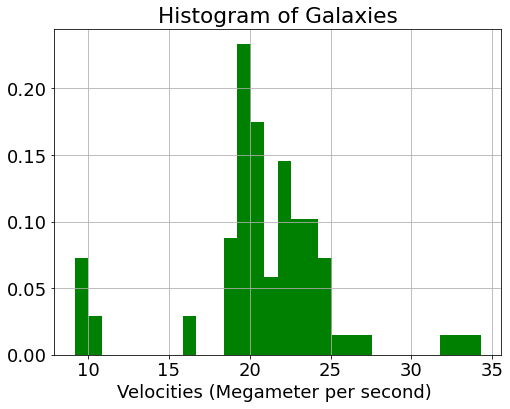

In [4]:
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(velocities,bins=30,color='green',density=True)
ax.grid(True)
ax.set_title('Histogram of Galaxies')
ax.set_xlabel('Velocities (Megameter per second) ')
plt.show()

In [5]:
## Implementation references slides from Module 6 from Statistical Modeling I (Dr. Sarkar)
def initialize_state(K, data, seed, use_kmeans=True):
    """
    initialize_state creates a {state} with [k] normal location-scale components fitting to [data] array
    using random numbers generated from [seed] seed.
    {state} contains information about the priors and samples for normal mean, normal variance 
    and mixture probablities, as well as some other experimental parameters/trackers.

    hyperparameters for priors:
    - alpha: concetration hyperparameter (dirichlet prior)
    - mu_0: mean hyperparameter (normal prior)
    - sigma2_0: variance hyperparemeter (normal prior)
    - a_0: shape hyperparameter (inv-ga full conditional)
    - b_0: scale hyperparameter (inv-ga full conditional)

    parameters sampled from full conditionals:
    - mu: mean for each component
    - sigma2: variance for each component
    - pi: mixing probability
    - z: indicator for observation in component (latent)

    experimental parameters/trackers:
    - components: # of components
    - iteration: iteration number (starts @ 0)
    - convergence: # of iterations to run for
    """
    np.random.seed(seed)
    # define hyperparameters for priors
    alpha = [1/K for k in range(K)]
    mu_0 = np.mean(data)
    sigma2_0 = np.var(data)
    a_0 = 1
    b_0 = 1
    # calculate theta_0
    pi = np.random.dirichlet(alpha)
    if use_kmeans:
        x = np.array(data).reshape(-1,1)
        kmeans = KMeans(n_clusters=K, random_state=seed).fit(x)
        mu = np.concatenate(kmeans.cluster_centers_)
    else:
        mu = np.random.normal(mu_0,sigma2_0,size=K)
    sigma2 = stats.invgamma(a=a_0,scale=b_0).rvs(K)
    z = np.zeros(len(data))
    # setup state dictionary
    state = {
        "hyperparameters":{
            "alpha":alpha,
            "mu_0":mu_0,
            "sigma2_0":sigma2_0,
            "a_0":a_0,
            "b_0":b_0
        },
        "parameters":{
            "pi":pi,
            "mu":mu,
            "sigma2":sigma2,
            "z":z
        },
        "experiment":{
            "components":K, 
        }

    }
    return state

def sample_z(data, state):
    """
    sample_z samples the component selected for each observation from [data] 
    from the full conditional based on a conjugate prior given [state]
    """
    K = state['experiment']['components']
    pi = state['parameters']['pi']
    mu = state['parameters']['mu']
    sigma2 = state['parameters']['sigma2']
    n = len(data)
    # calculate normal density for each data point for each component
    normal_pdfs = np.zeros(shape=(n,K))
    for i in range(n):
        for k in range(K):
            normal_pdfs[i][k] = stats.norm(loc=mu[k],scale=np.sqrt(sigma2[k])).pdf(data[i])
    # calculate new_pi
    new_pi = np.zeros(shape=(n,K))
    sums = np.sum(normal_pdfs * pi, axis=1)
    for i in range(n):
        for k in range(K):
            new_pi[i][k] = pi[k]*normal_pdfs[i][k]/sums[i]
    # sample z for each observation
    z = np.zeros(n)
    for i in range(n):
        z[i] = np.random.choice(K, p=new_pi[i])
    z = z.astype(int)
    counts = np.bincount(z,minlength=K)
    # update latent z and respective pi
    state['parameters']['z'] = z
    state['parameters']['pi'] = counts / np.sum(counts)
    # pass along counts to save calculation time
    return state, counts

def sample_mu(data, state, counts):
    """
    sample_mu samples the component mean from the full conditional based
    on a conjugate prior
    """
    mu_0 = state['hyperparameters']['mu_0']
    sigma2_0 = state['hyperparameters']['sigma2_0']
    K = state['experiment']['components'] 
    sigma2 = state['parameters']['sigma2']
    z = state['parameters']['z']
    # calculate ybar and normal variance param sigma2_n
    ybar = np.zeros(K)
    sigma2_n = np.zeros(K)
    for k in range(K):
        data_k = data[np.where(z==k)[0]] # indicies i where z_i=k
        sigma2_n[k] = 1/(1/sigma2_0 + counts[k]/sigma2[k])
        if len(data_k) > 0:
            ybar[k] = np.sum(data_k) / counts[k]
        else:
            ybar[k]=0
    # calculate normal mean param mu_n
    mu_n = np.zeros(K)
    for k in range(K):
        mu_n[k] = sigma2_n[k]*(mu_0/sigma2_0 + counts[k]*ybar[k]/sigma2[k])
    # sample mu from N(mu_n,sigma_n)
    tmp = np.zeros(K)
    for k in range(K):
        tmp[k] = np.random.normal(mu_n[k],sigma2_n[k])
    state['parameters']['mu'] = tmp
    # pass along ybar and counts to save calculation time
    return state, counts, ybar

def sample_sigma2(data, state, counts, ybar):
    """
    sample_sigma2 samples the component variance from the full conditional based
    on a conjugate prior
    """
    a_0 = state['hyperparameters']['a_0']
    b_0 = state['hyperparameters']['b_0']
    K = state['experiment']['components'] 
    mu = state['parameters']['mu']
    z = state['parameters']['z']
    # calculate s2
    s2 = np.zeros(K)
    for k in range(K):
        data_k = data[np.where(z==k)[0]]
        if len(data_k) > 0:
            s2[k] = np.var(data_k)
        else:
            s2[k]=0
    # calculate inv-ga alpha and beta params
    a_n = np.zeros(K)
    b_n = np.zeros(K)
    for k in range(K):
        a_n[k] = a_0 + counts[k]/2
        b_n[k] = b_0 + (counts[k]-1)*s2[k]/2 + (counts[k]*(ybar[k]-mu[k])**2)/2
    # sample from Inv-Ga(a_nk,b_nk)
    tmp = np.zeros(K)
    for k in range(K):
        tmp[k] = stats.invgamma(a=a_n[k],scale=b_n[k]).rvs(1)
    state['parameters']['sigma2'] = tmp
    return state

def create_df(params, state):
    K = state['experiment']['components']
    mu_labels = [f'mu_{k}' for k in range(K)]
    sigma2_labels = [f'sigma2_{k}' for k in range(K)]
    pi_labels = [f'pi_{k}' for k in range(K)]
    col_names = np.concatenate((mu_labels, sigma2_labels, pi_labels))
    df = pd.DataFrame(data = params, columns = col_names)
    return df

In [7]:
## Running Gibbs Sampler
# experiment parameters
n_iters = 5000
burn_in = 2000
thin_step = 10
# run fitting over different number of components
for k in [3,4,5,6,7,8]:
    start = time.time()
    print(f"Fitting {k} components...")
    state = initialize_state(k,velocities,seed=seed,use_kmeans=False)
    arr = []
    # sample until desired number of iterations (i.e no convergence criteria)
    for i in range(n_iters):
        print(k,f" Iteration {i+1} / {n_iters}")
        state, counts = sample_z(velocities, state)
        state, counts, ybar = sample_mu(velocities, state, counts)
        state = sample_sigma2(velocities, state, counts, ybar)
        params = state['parameters']
        mu = params['mu']
        sigma2 = params['sigma2']
        pi = params['pi']
        arr.append(np.concatenate((mu,sigma2,pi)).tolist())
    # burn-in and thinning
    arr_burn = arr[burn_in:]
    arr_thin = []
    for i in range(len(arr_burn)):
        if not i%thin_step:
            arr_thin.append(arr_burn[i])
    # save data to csv
    df = create_df(arr_thin, state)
    df.to_csv(f"{k}_components_results_q5_nokmeans.csv")
    end = time.time()
    print(f"... completed in {round(end - start,3)} seconds.")

Fitting 3 components...
3  Iteration 1 / 5000
3  Iteration 2 / 5000
3  Iteration 3 / 5000
3  Iteration 4 / 5000
3  Iteration 5 / 5000
3  Iteration 6 / 5000
3  Iteration 7 / 5000
3  Iteration 8 / 5000
3  Iteration 9 / 5000
3  Iteration 10 / 5000
3  Iteration 11 / 5000
3  Iteration 12 / 5000
3  Iteration 13 / 5000
3  Iteration 14 / 5000
3  Iteration 15 / 5000
3  Iteration 16 / 5000
3  Iteration 17 / 5000
3  Iteration 18 / 5000
3  Iteration 19 / 5000
3  Iteration 20 / 5000
3  Iteration 21 / 5000
3  Iteration 22 / 5000
3  Iteration 23 / 5000
3  Iteration 24 / 5000
3  Iteration 25 / 5000
3  Iteration 26 / 5000
3  Iteration 27 / 5000
3  Iteration 28 / 5000
3  Iteration 29 / 5000
3  Iteration 30 / 5000
3  Iteration 31 / 5000
3  Iteration 32 / 5000
3  Iteration 33 / 5000
3  Iteration 34 / 5000
3  Iteration 35 / 5000
3  Iteration 36 / 5000
3  Iteration 37 / 5000
3  Iteration 38 / 5000
3  Iteration 39 / 5000
3  Iteration 40 / 5000
3  Iteration 41 / 5000
3  Iteration 42 / 5000
3  Iteration 43 / 5

In [9]:
## Density and credible region calculations
def calc_pdfs(K,df,data):
    """
    calc_pdfs calculates the densities for mixture gaussian with parameters in [df] with [K] components
    """
    mu_labels = [f'mu_{k}' for k in range(K)]
    sigma2_labels = [f'sigma2_{k}' for k in range(K)]
    pi_labels = [f'pi_{k}' for k in range(K)]

    pdfs = []
    df = df.reset_index() 
    xs = np.linspace(data.min()-2, data.max()+2, 100)
    for index, row in df.iterrows():
        mu_arr = []
        sigma2_arr = []
        pi_arr = []
        for i in mu_labels:
            mu_arr.append(row[i])
        for j in sigma2_labels:
            sigma2_arr.append(row[j])
        for k in pi_labels:
            pi_arr.append(row[k])
        pdfs.append(calc_pdf(xs, mu_arr, sigma2_arr, pi_arr))
    return pdfs
 
def calc_pdf(support, mu, sigma2, pi):
    """
    calc_pdf calculates the density over region [support] for mixture gaussian with parameters
    mean [pi], variance [sigma2] and mixing probability [pi] 
    """
    K = len(mu)
    pdf = np.zeros_like(support)
    for i in range(len(pdf)):
        tmp = 0
        for k in range(K):
            tmp += pi[k] * stats.norm(mu[k],sigma2[k]).pdf(support[i])
        pdf[i] = tmp
    return pdf

def calc_credible_regions(ys, alpha):
    """
    calc_credible_region computes the (1-[alpha])100 percentage credible region
    on data [ys]
    """
    ys_stacked = np.stack(ys, axis=-1)
    lowers, means, uppers = [], [], []
    for y in ys_stacked:
        means.append(np.mean(y))
        lowers.append(np.percentile(a=y, q=(alpha/2)*100))
        uppers.append(np.percentile(a=y, q=(1-alpha/2)*100))
    return lowers, means, uppers

In [18]:
## Use Gibbs Samples to calculate credible regions 
dfs = {}
regions = []
Ks = [3,4,5,6,7,8]
alpha = 0.1
for K in Ks:
    with open(f"{K}_components_results_q5_nokmeans.csv",'r') as file:
        print(f'Generating credible regions for component {K}...')
        start = time.time()
        # calculate confidence regions
        df = pd.read_csv(file)
        pdfs = calc_pdfs(K,df,velocities)
        lowers, means, uppers = calc_credible_regions(pdfs, alpha)
        # store results
        dfs[f'{K}'] = df
        regions.append((lowers,means,uppers))
        end = time.time()
        print(f'... finished in {end - start} seconds.')

Generating credible regions for component 3...
... finished in 58.14292597770691 seconds.
Generating credible regions for component 4...
... finished in 70.57892513275146 seconds.
Generating credible regions for component 5...
... finished in 87.1573531627655 seconds.
Generating credible regions for component 6...
... finished in 104.57427620887756 seconds.
Generating credible regions for component 7...
... finished in 122.68789029121399 seconds.
Generating credible regions for component 8...
... finished in 139.67327213287354 seconds.


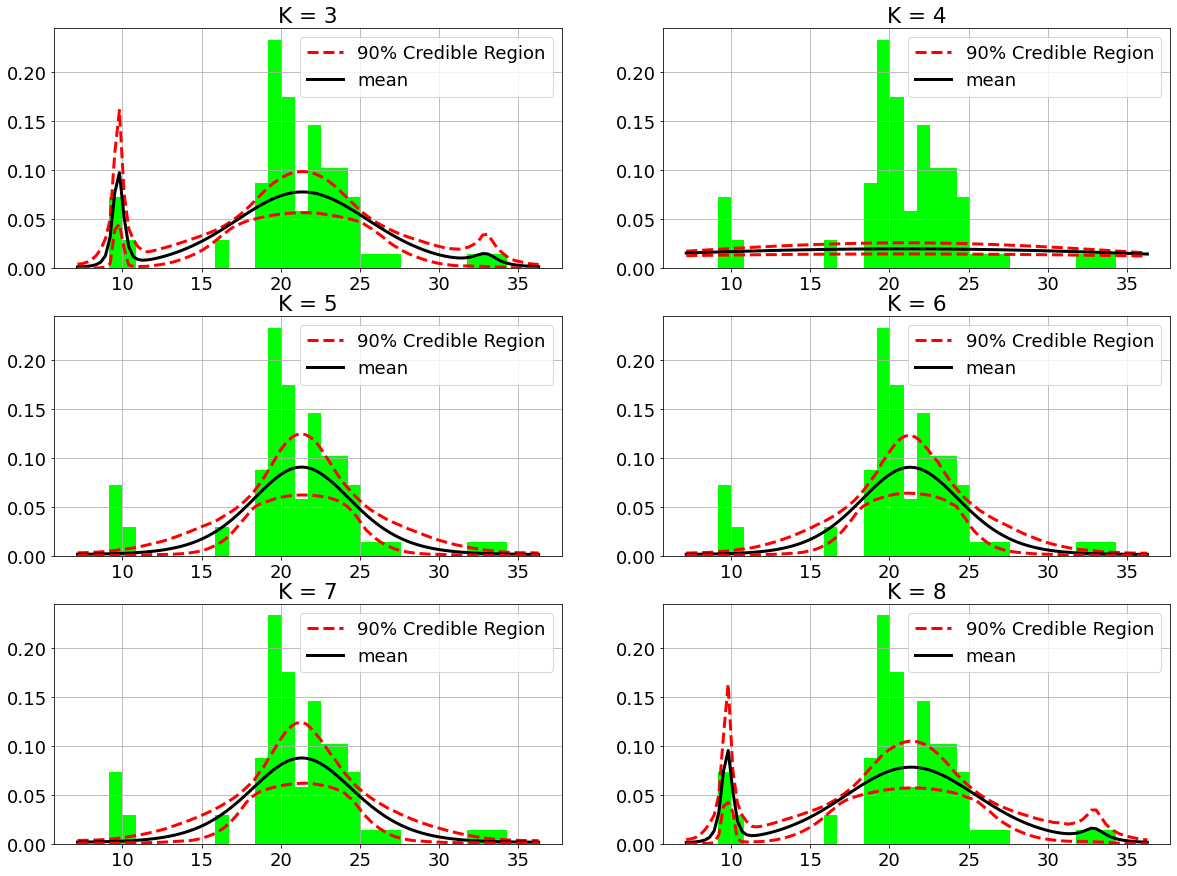

In [19]:
## Plotting of credible regions
fig,axs = plt.subplots(nrows=3,ncols=2,figsize=(20,15))
xs = np.linspace(velocities.min()-2, velocities.max()+2, 100)
Ks = [3,4,5,6,7,8]
for idx, ax in enumerate(axs.flatten()):
    ax.hist(velocities,bins=30,color='lime',density=True)
    ax.set_title(f'K = {Ks[idx]}')
    ax.plot(xs,regions[idx][2],  linewidth=3,linestyle='--',label=f'{int((1-alpha)*100)}% Credible Region',color='red')
    ax.plot(xs,regions[idx][1],  linewidth=3,label='mean',color='black')
    ax.plot(xs,regions[idx][0], linewidth=3,color='red',linestyle='--')
    ax.grid(True)
    ax.legend()
plt.savefig('gibbs_samples_credible_regions_nokmeans.png')
plt.show()